# Kojak

Classifying the meaning of homographs by their context.

In [1]:
import numpy as np
import pandas as pd
import gensim
import json
import re
import random

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from collections import Counter, defaultdict


Using Theano backend.


In [2]:
# Declare stopwords, preprocess the data from source file abstracts.json

stop = stopwords.words('english')
stop += ['?','!','.',',',':',';','[',']','[]','“' ]
stop += ['.', ',', '(', ')', "'", '"',"''",'""',"``",'”', '“', '?', '!', '’', 'et', 'al.', 'study', ""]
stop = set(stop)

class MyPapers(object):
    # a memory-friendly way to load a large corpora
     def __init__(self, dirname):
            self.dirname = dirname
 
     def __iter__(self):
        with open(self.dirname) as data_file:    
            data = json.load(data_file)
        # iterate through all file names in our directory
        for paper in data:
            sentences = sent_tokenize(paper['full_text'])
            for sentence in sentences:
                try:
                    line = re.sub(r'[?\.,!:;\(\)“\[\]]',' ',sentence)
                    line = [word for word in line.lower().split() if word not in stop]
                    yield line
                except:
                    print("Empty line found")
                    
class MySentences(object):
    # a memory-friendly way to load a large corpora
     def __init__(self, dirname):
            self.dirname = dirname
 
     def __iter__(self):
        with open(self.dirname) as data_file:    
            data = json.load(data_file)
        # iterate through all file names in our directory
        for paper in data:
            sentences = sent_tokenize(paper['full_text'])
            for sentence in sentences:
                try:
                    line = re.sub(r'[?\.,!:;\(\)“\[\]]',' ',sentence)
                    yield line
                except:
                    print("Empty line found")

In [3]:
#Instantiate iterable on the data

#papers is an iterable of scholarly papers, tokenized for prcessing
papers = MyPapers('../data/train_data.json') 


In [4]:
# Arguments: Finds the corresponding source sentance in the source .json file
# that corresponds to the given tokenized word_list

def find_sentence(json_file, word_list):
    words = []
    for w in word_list:
        for _ in w.split('_'):
            words.append(_)
    for paper in json_file:
        for sentence in sent_tokenize(paper['full_text']):
            if all(word in sentence.lower() for word in words):
                return sentence
            
#Identifies and transforms corpus (An iterator) to contain bigrams and trigrams

def MyPapers_plus(papers):
    
    phrases = gensim.models.phrases.Phrases(sentences = papers, min_count = 5, threshold = 150)
    bigram = gensim.models.phrases.Phraser(phrases)
    phrases2 = gensim.models.phrases.Phrases(sentences = bigram[papers], min_count = 5, threshold = 300)
    trigram = gensim.models.phrases.Phraser(phrases2)
    
    return trigram[bigram[papers]]

# Takes list of word tokens as arguments
# Returns a list of vectors whose components are the arithmetic mean of the 
# corresponding component of all of the input vectors

def get_vectors(word_list):
    vecs = []
    for word in word_list:
        try:
            vecs.append(vectors[word])
        except:
            print("{} missing from vocabulary".format(word))
            #continue
    return vecs

# The function takes as arguments a list of tokenized documents and a window size
# and returns each word in the document along with its window context as a tuple

def generate_word_counts(documents):
    counts = Counter()
    
    for document in documents:        
        for word in set(document):                    
            counts[word] += 1
            
    return counts

In [5]:
# declaring the multiple definitions of "charge" and "state"

charge_def = {1:"(criminal law) a pleading describing some wrong or offense",
              2:"a quantity of explosive to be set off at one time",
              3:"the quantity of unbalanced electricity in a body (either positive or negative) and construed as an excess or deficiency of electrons",
              4:"request for payment of a debt"}

state_def = {1:"the condition of matter with respect to structure, form, constitution, phase, or the like",
            2:"a politically unified people occupying a definite territory",
            3: "express something definitely or clearly in speech or writing"}


In [6]:
# import pretrained word embeddings model

model = gensim.models.word2vec.Word2Vec.load("../data/journal.txt")

In [10]:
model.corpus_count
vectors = model.wv
vocab = vectors.vocab
word_counts = generate_word_counts(MyPapers_plus(papers))
len(vectors.vocab)

127777

In [6]:
# Arguments: List of tokenized word sequence and returns word sequences corresponding to window_size

def target_context(sentence, target, window_size = 6):
    maxlen = window_size*2
    
    L = len(sentence)
    # Choose the target word
    target_arg = sentence.index(target)

    s = target_arg-window_size
    e = target_arg+window_size+1

    context_words = []
    # Create the input/outputs for skipgrams
    for i in range(s, e):
        if 0 <= i < L:
            context_words.append(sentence[i])
            
    return context_words

def read_glossary(glossary):
    
    vector_glossary = dict()
    
    for k, v in glossary.items():
        vector_glossary[k] = {key:vector_average2(tokenize.word_tokenize(value)) for (key,value) in v.items()}
    
    return vector_glossary

def get_target_sentences(documents, target):
    
    context_sentences = []

    for document in documents:
        #print(document[:15])
        sentence = document
        if target in sentence:
            #str_sentence = streamlined_sentence(sentence)
            #print[str_sentence]
            #sentence.remove(target)
            context_sentences.append(sentence)
            
    return context_sentences

In [7]:
# Build a corpus of sentences containing the word state

target = ' state '
sentences = MySentences('../data/train_data.json')
STATE_sentences = get_target_sentences(sentences,target)

In [8]:
len(STATE_sentences)

1874

In [32]:
STATE_sentences = random.sample(STATE_sentences, 600)
sense_label = np.zeros(len(STATE_sentences))
sense_label.fill(-1)
STATE_df = pd.DataFrame({'sentences':STATE_sentences, 'sense_labels':sense_label})
STATE_df.to_pickle('STATE_df.pkl')


In [10]:
# Pickle small slices of the previously created dataframe to label through the terminal
STATE_df = pd.read_pickle('STATE_df.pkl')

start = 0
labeled_frames = []

In [41]:
df = STATE_df[start:start+20]
df.to_pickle('STATE_df.pkl')
start+=20

In [42]:
labeled_frames.append(pd.read_pickle('STATE_df_labeled'))

In [43]:
len(labeled_frames)

11

In [44]:
# Concatenate the labeled dataframe slices
STATE_df_labeled = pd.concat(labeled_frames)

In [48]:
# Filter out indeterminate labels
STATE_df_labeled['sense_labels'] = STATE_df_labeled['sense_labels'].apply(lambda x : -1 if x == '' else x )
STATE_df_labeled['sense_labels'] = STATE_df_labeled['sense_labels'].apply(lambda x : int(x) )
STATE_df_labeled = STATE_df_labeled[STATE_df_labeled['sense_labels'] > 0]

In [50]:
def tokenize_plus(line):
    line = re.sub(r'[?\.,!:;\(\)“\[\]]',' ',line)
    line = [word for word in line.lower().split() if word not in stop]
    
    return line

STATE_df_labeled['tokenized_sentences'] = STATE_df_labeled['sentences'].apply(tokenize_plus)

In [53]:
target = 'state'
STATE_df_labeled['window'] = STATE_df_labeled['tokenized_sentences'].apply(lambda x : target_context(x, target))

In [54]:
STATE_df_labeled.head()

,sense_labels,sentences,tokenized_sentences,window
220,2,In this regard sovereignty is conditional th...,"[regard, sovereignty, conditional, state’s, le...","[humanitarian, intervention, means, military, ..."
221,2,Breidahl argues that similar strong and roote...,"[breidahl, argues, similar, strong, rooted, no...","[breidahl, argues, similar, strong, rooted, no..."
222,2,We thus reanalyse the most up-to-date pan-Amaz...,"[thus, reanalyse, up-to-date, pan-amazon, data...","[dynamics, decade-by-decade, level, biogeograp..."
223,2,However as Chinese firms become more involved...,"[however, chinese, firms, become, involved, fo...","[organisations, leading, potential, tension, d..."
224,2,Despite beginning from very similar innovation...,"[despite, beginning, similar, innovation, syst...","[model, transition, economies, noting, importa..."


In [55]:
df = pd.read_pickle('STATE_df_labeled.pkl')

In [56]:
STATE_df_labeled = pd.concat([STATE_df_labeled,df])

In [57]:
len(STATE_df_labeled)

434

In [76]:
STATE_df_labeled.to_pickle('STATE_df_labeled.pkl')
STATE_df[start:].to_pickle('STATE_df.pkl')

In [177]:
#Function no longer used

def pad_vector_sequence(vector_list, max_len = 12):
    array_len = len(vector_list)
    if array_len < max_len:
        new = list(vector_list) + (max_len-array_len)*[0]
        return new
    else:
        return np.array(vector_list)

In [4]:
STATE_df_labeled = pd.read_pickle('STATE_df_labeled.pkl')

### Validation data

In [93]:
# Build a corpus of sentences containing the word state

target = ' state '
sentences = MySentences('../data/validation_data.json')
STATE_sentences = get_target_sentences(sentences,target)

In [94]:
#STATE_sentences = random.sample(STATE_sentences, 600)
sense_label = np.zeros(len(STATE_sentences))
sense_label.fill(-1)
STATE_val_df = pd.DataFrame({'sentences':STATE_sentences, 'sense_labels':sense_label})
STATE_val_df.to_pickle('STATE_val_df.pkl')


In [95]:
len(STATE_sentences)

273

In [96]:
# Pickle small slices of the previously created dataframe to label through the terminal
#STATE_val_df = pd.read_pickle('STATE_val_df.pkl')

start = 0
labeled_val_frames = []

In [136]:
df = STATE_val_df[start:start+20]
df.to_pickle('STATE_val_df.pkl')
start+=20

In [137]:
labeled_val_frames.append(pd.read_pickle('STATE_val_df_labeled'))

In [138]:
len(labeled_val_frames)

14

In [139]:
# Concatenate the labeled dataframe slices
STATE_val_df_labeled = pd.concat(labeled_val_frames)

In [140]:
# Filter out indeterminate labels
STATE_val_df_labeled['sense_labels'] = STATE_val_df_labeled['sense_labels'].apply(lambda x : -1 if x == '' else x )
STATE_val_df_labeled['sense_labels'] = STATE_val_df_labeled['sense_labels'].apply(lambda x : int(x) )
STATE_val_df_labeled = STATE_val_df_labeled[STATE_val_df_labeled['sense_labels'] > 0]

In [150]:
def tokenize_plus(line):
    line = re.sub(r'[?\.,!:;\(\)“\[\]]',' ',line)
    line = [word for word in line.lower().split() if word not in stop]
    
    return line

STATE_val_df_labeled['tokenized_sentences'] = STATE_val_df_labeled['sentences'].apply(tokenize_plus)

In [151]:
target = 'state'
STATE_val_df_labeled['window'] = STATE_val_df_labeled['tokenized_sentences'].apply(lambda x : target_context(x, target))

In [152]:
STATE_val_df_labeled.to_pickle('STATE_val_df_labeled')

In [26]:
STATE_df_labeled = pd.read_pickle('STATE_df_labeled.pkl')
STATE_val_df_labeled = pd.read_pickle('STATE_val_df_labeled')

## LSTM classifier for word sense

In [27]:
# keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Activation, SimpleRNN, GRU, LSTM, Bidirectional, Convolution1D, MaxPooling1D, Merge, Dropout
from IPython.display import SVG
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop

In [28]:
Y = keras.utils.to_categorical(STATE_df_labeled['sense_labels'].apply((lambda x: x-1)), num_classes=3)
Y_val = keras.utils.to_categorical(STATE_val_df_labeled['sense_labels'].apply((lambda x: x-1)), num_classes=3)

In [29]:
def clean_lists(x):
    return " ".join(x)

STATE_df_labeled['clean'] = STATE_df_labeled['window'].apply(clean_lists)
STATE_val_df_labeled['clean'] = STATE_val_df_labeled['window'].apply(clean_lists)

In [30]:
corpus = [ x for x in STATE_df_labeled['clean']]
val_corpus = [ x for x in STATE_val_df_labeled['clean']]

In [31]:
my_filter= '!\“#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
tokenizer = Tokenizer(filters=my_filter)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

#tokenizer2 = Tokenizer(filters=my_filter)
tokenizer.fit_on_texts(val_corpus)
val_sequences = tokenizer.texts_to_sequences(val_corpus)


## Building a LSTM

In [32]:
sequences = sequence.pad_sequences(sequences, maxlen=12)
val_sequences = sequence.pad_sequences(val_sequences, maxlen=12)

In [33]:
# Train, test, split
X_train,X_test, y_train,  y_test = sequences, val_sequences, Y, Y_val




In [34]:
max_features = len(tokenizer.word_index) + 1
nb_epoch = 20

# cut texts after this number of words (among top max_features most common words)
batch_size = 32

LSTM_model = Sequential()
LSTM_model.add(Embedding(max_features, output_dim=128))
# Bidirectional LSTM!!!
LSTM_model.add(Bidirectional(LSTM(128)))
LSTM_model.add(Dropout(0.5))
LSTM_model.add(Dense(3, activation='sigmoid'))


In [35]:
LSTM_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('Train...')
history = LSTM_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_data = [X_test, y_test])

Train...
Train on 434 samples, validate on 271 samples
Epoch 1/20
434/434 [==============================] - 0s - loss: 1.0508 - acc: 0.5184 - val_loss: 0.9568 - val_acc: 0.5240
Epoch 2/20
434/434 [==============================] - 0s - loss: 0.8639 - acc: 0.5438 - val_loss: 0.9446 - val_acc: 0.5240
Epoch 3/20
434/434 [==============================] - 0s - loss: 0.7745 - acc: 0.5438 - val_loss: 0.9220 - val_acc: 0.5240
Epoch 4/20
434/434 [==============================] - 0s - loss: 0.5210 - acc: 0.7442 - val_loss: 1.0738 - val_acc: 0.5314
Epoch 5/20
434/434 [==============================] - 0s - loss: 0.1614 - acc: 0.9424 - val_loss: 2.0652 - val_acc: 0.4576
Epoch 6/20
434/434 [==============================] - 0s - loss: 0.0516 - acc: 0.9931 - val_loss: 2.0714 - val_acc: 0.4576
Epoch 7/20
434/434 [==============================] - 0s - loss: 0.0221 - acc: 1.0000 - val_loss: 2.2717 - val_acc: 0.4871
Epoch 8/20
434/434 [==============================] - 0s - loss: 0.0099 - acc: 1.000

In [16]:
print(history.history['val_loss'])

[0.96163911881042141, 0.92136411385342643, 0.93627227892295017, 1.1494698581660365, 1.9204266660767728, 2.3904732593311153, 2.6893451468970944, 2.4579624909756368, 3.4392032077831534, 2.1637966254540477, 2.1584397066123371, 2.3695225786019076, 2.5054884563952795, 2.5872767015576801, 2.6410739386653548, 2.68239881103769, 2.7194641533812915, 2.7661568080367198, 2.7999256017903122, 2.8300447032900315]


In [17]:
accuracy_history = []
accuracy_history.append(history.history['acc'])

In [18]:
LSTM_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('Train...')
history = LSTM_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_data = [X_test, y_test])

Train...
Train on 434 samples, validate on 271 samples
Epoch 1/20
434/434 [==============================] - 0s - loss: 9.8255e-04 - acc: 1.0000 - val_loss: 3.1283 - val_acc: 0.4244
Epoch 2/20
434/434 [==============================] - 0s - loss: 3.8422e-04 - acc: 1.0000 - val_loss: 3.1233 - val_acc: 0.4207
Epoch 3/20
434/434 [==============================] - 0s - loss: 1.6277e-04 - acc: 1.0000 - val_loss: 3.3384 - val_acc: 0.4207
Epoch 4/20
434/434 [==============================] - 0s - loss: 9.8870e-05 - acc: 1.0000 - val_loss: 3.7294 - val_acc: 0.4096
Epoch 5/20
434/434 [==============================] - 0s - loss: 4.1781e-05 - acc: 1.0000 - val_loss: 3.8763 - val_acc: 0.4022
Epoch 6/20
434/434 [==============================] - 0s - loss: 5.7276e-05 - acc: 1.0000 - val_loss: 4.1570 - val_acc: 0.3985
Epoch 7/20
434/434 [==============================] - 0s - loss: 1.5411e-05 - acc: 1.0000 - val_loss: 4.2568 - val_acc: 0.3948
Epoch 8/20
434/434 [==============================] - 0s

In [19]:
accuracy_history.append(history.history['acc'])

In [20]:
LSTM_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('Train...')
history = LSTM_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_data = [X_test, y_test])

Train...
Train on 434 samples, validate on 271 samples
Epoch 1/20
434/434 [==============================] - 0s - loss: 1.3217e-05 - acc: 1.0000 - val_loss: 4.6100 - val_acc: 0.5018
Epoch 2/20
434/434 [==============================] - 0s - loss: 2.1884e-06 - acc: 1.0000 - val_loss: 5.4533 - val_acc: 0.5277
Epoch 3/20
434/434 [==============================] - 0s - loss: 8.6153e-07 - acc: 1.0000 - val_loss: 5.6848 - val_acc: 0.5240
Epoch 4/20
434/434 [==============================] - 0s - loss: 1.1941e-06 - acc: 1.0000 - val_loss: 5.6078 - val_acc: 0.5055cc: 1
Epoch 5/20
434/434 [==============================] - 0s - loss: 6.7996e-07 - acc: 1.0000 - val_loss: 5.6196 - val_acc: 0.4945
Epoch 6/20
434/434 [==============================] - 0s - loss: 4.6365e-07 - acc: 1.0000 - val_loss: 5.7448 - val_acc: 0.5129
Epoch 7/20
434/434 [==============================] - 0s - loss: 5.1365e-07 - acc: 1.0000 - val_loss: 5.7792 - val_acc: 0.5129
Epoch 8/20
434/434 [==============================]

In [21]:
accuracy_history.append(history.history['acc'])

In [36]:
LSTM_model.predict(val_sequences[0:1], batch_size=32, verbose=0)

array([[  7.79900700e-02,   1.62087765e-03,   6.75133342e-05]], dtype=float32)

In [22]:
import matplotlib.pyplot as plt

% matplotlib inline

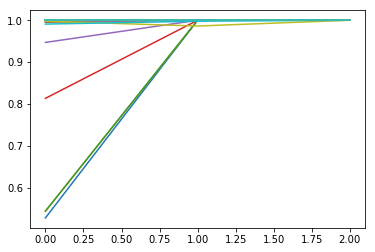

In [25]:
x = range(0,len(accuracy_history))
ax = plt.plot(x,accuracy_history)
